In [1]:
import numpy as np
from pprint import pprint
from copy import deepcopy


from laboneq.contrib.example_helpers.generate_descriptor import generate_descriptor
#from laboneq.contrib.example_helpers.generate_device_setup import generate_device_setup
from laboneq.dsl.device import DeviceSetup




descriptor = generate_descriptor(
    #pqsc=[""], # 장비 여러개 사용시
    shfqc_6=["DEV12256"],
    number_data_qubits=6,
    multiplex=True,
    number_multiplex=6,
    include_cr_lines=True,
    include_ef_lines=True,
    get_zsync=False,  # Only set to True when using real device
    save = True,
    filename="TG_RIP",
    ip_address="192.168.0.83"
)


#descriptor
setup = DeviceSetup.from_descriptor(yaml_text=descriptor, server_host="192.168.0.83")
#setup
setup.instruments[0].device_options = 'SHFQC/PLUS/QC6CH'
#setup.instruments

In [2]:
from laboneq.simple import Session
session = Session(setup)
session.connect(ignore_version_mismatch=False, do_emulation=False)
#session.disconnect()

[2026.01.05 00:28:29.687] INFO    Logging initialized from [Default inline config in laboneq.laboneq_logging] logdir is /home/yalgaeahn/JSAHN/qubit-experiment/examples/selectiveRIP/laboneq_output/log
[2026.01.05 00:28:29.688] INFO    VERSION: laboneq 25.10.2
[2026.01.05 00:28:29.689] INFO    Connecting to data server at 192.168.0.83:8004
[2026.01.05 00:28:29.766] INFO    Connected to Zurich Instruments LabOne Data Server version 25.10.1.4 at 192.168.0.83:8004
[2026.01.05 00:28:29.798] INFO    Configuring the device setup
[2026.01.05 00:28:29.821] INFO    The device setup is configured


In [3]:
from qpu_types import TransmonQubit, TransmonQubitParameters
from helper import load_qubit_parameters, save_qubit_parameters
from operations import TransmonOperations
from laboneq.dsl.quantum.qpu import QPU, QuantumPlatform



_loaded_qubits = load_qubit_parameters(filename="latest") 
#qubits = TransmonQubit.from_device_setup(setup) # Also can be done with load_qubit_parameters 
qubits = list(_loaded_qubits.values())





qpu = QPU(quantum_elements=qubits, quantum_operations=TransmonOperations())
#quantum_platform = QuantumPlatform(setup=setup, qpu=qpu)

# qpu.topology.add_edge("bus", "q16", "q17")
# qpu.topology.add_edge("bus", "q17", "q18")
# qpu.topology.add_edge("bus", "q18", "q19")
# qpu.topology.plot()




from laboneq.simple import workflow
folder_store = workflow.logbook.FolderStore("./experiment_store") 
folder_store.activate()
#folder_store.deactivate()
#workflow.logbook.LoggingStore().activate()
#workflow.logbook.LogbookStore().deactivate()


LOADED:./qubit_parameters/20260104-2259_sample2.json


('measure',
 {'amplitude': 0.7,
  'length': 1.2e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
[2026.01.04 23:22:01.825] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.01.04 23:22:01.825] INFO      Workflow 'echo': execution started at 2026-01-04 14:22:01.824844Z             
[2026.01.04 23:22:01.825] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.01.04 23:22:01.835] INFO    Task 'temporary_qpu': started at 2026-01-04 14:22:01.835487Z
[2026.01.04 23:22:01.837] INFO    Task 'temporary_qpu': ended at 2026-01-04 14:22:01.836825Z
[2026.01.04 23:22:01.841] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-01-04 
[2026.01.04 23:22:01.841] INFO    14:22:01.840829Z
[2026.01.04 23:22:01.843] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-01-04 14:22:01.843034Z
[2026.01.04 23:22:01.844] INFO    Ta

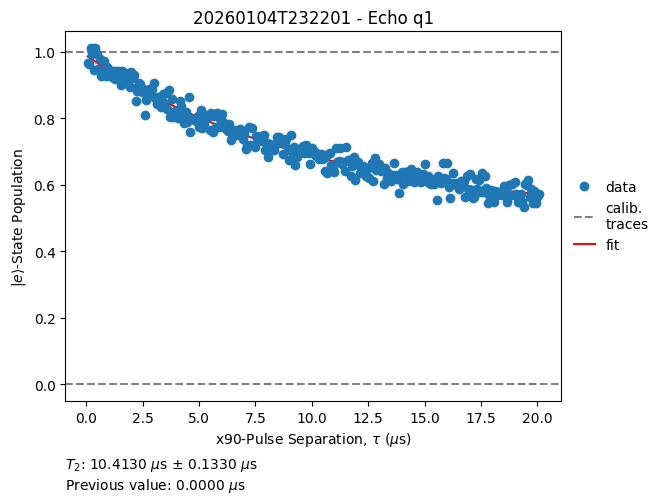

In [4]:
from experiments import echo 

q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
delays = np.linspace(0,20e-6,301)
detunings = 0.5e6,
pprint(q.readout_parameters())
#######################################################################
options = echo.experiment_workflow.options()
options.update(False)
options.count(1024)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = echo.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    #detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)
ramsey_result.tasks['analysis_workflow'].tasks['plot_population'].output['q1']

# Ramsey

In [ ]:
qubits[1].parameters

In [7]:
from laboneq_applications.experiments import ramsey

q = qubits[1]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
#temp_pars.readout_integration_length= 1e-6
temporary_parameters[q.uid] = temp_pars
#######################################################################
delays = np.linspace(0,5e-6,301)
detunings = 2e6 #4e6,
pprint(q.readout_parameters())
#######################################################################
options = ramsey.experiment_workflow.options()
options.update(True)
options.count(512)
options.use_cal_traces(True)
# Build and run Ramsey workflow (no explicit command table options required)
ramsey_wf = ramsey.experiment_workflow(
    session=session,
    qpu=qpu,
    qubits=q,
    delays=delays,
    detunings=detunings,
    options=options,
    temporary_parameters=temporary_parameters
)
ramsey_result = ramsey_wf.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(ramsey_result.tasks['analysis_workflow'].output)
#ramsey_result.tasks['analysis_workflow'].tasks['plot_population'].output['q0']

('measure',
 {'amplitude': 0.7,
  'length': 1.2e-06,
  'pulse': {'function': 'GaussianSquare',
            'risefall_sigma_ratio': 3.0,
            'sigma': 0.2}})
[2026.01.04 23:24:53.298] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.01.04 23:24:53.298] INFO      Workflow 'ramsey': execution started at 2026-01-04 14:24:53.298020Z           
[2026.01.04 23:24:53.298] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.01.04 23:24:53.307] INFO    Task 'temporary_qpu': started at 2026-01-04 14:24:53.306975Z
[2026.01.04 23:24:53.308] INFO    Task 'temporary_qpu': ended at 2026-01-04 14:24:53.307906Z
[2026.01.04 23:24:53.310] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-01-04 
[2026.01.04 23:24:53.310] INFO    14:24:53.310338Z
[2026.01.04 23:24:53.311] INFO    Task 'temporary_quantum_elements_from_qpu': ended at 2026-01-04 14:24:53.311189Z
[2026.01.04 23:24:53.312] INFO    Ta

[2026.01.04 23:24:53.367] ERROR   Task 'compile_experiment': failed at 2026-01-04 14:24:53.367430Z with: 


[2026.01.04 23:24:53.368] ERROR   LabOneQException("Content of section 'measure_q1_0' (1.200e+00 us) does not fit 


[2026.01.04 23:24:53.368] ERROR   LabOneQException("Content of section 'measure_q1_0' (1.200e+00 us) does not fit 


[2026.01.04 23:24:53.368] ERROR   into the requested fixed section length (6.000e-01 us)")


[2026.01.04 23:24:53.368] ERROR   into the requested fixed section length (6.000e-01 us)")


[2026.01.04 23:24:53.369] INFO    Task 'compile_experiment': ended at 2026-01-04 14:24:53.369360Z
[2026.01.04 23:24:53.370] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.01.04 23:24:53.370] INFO      Workflow 'ramsey': execution ended at 2026-01-04 14:24:53.369955Z             
[2026.01.04 23:24:53.370] INFO     ────────────────────────────────────────────────────────────────────────────── 


LabOneQException: Content of section 'measure_q1_0' (1.200e+00 us) does not fit into the requested fixed section length (6.000e-01 us)

In [ ]:
qubits[0].parameters.resonance_frequency_ge

# Power calculation

In [ ]:
from helper import adjust_amplitude_for_output_range, calculate_power
#adjust_amplitude_for_output_range(initial_output_dbm=0, initial_amplitude= 0.002, new_output_dbm=-5)
calculate_power(output_dbm=10, amplitude=0.004,attenuation=[])

# Coherence Spectroscopy

ECHO 제거함

In [ ]:
qubits[4].parameters.resonance_frequency_ge = 6.4203e9 #mode3
qubits[2].parameters.resonance_frequency_ge = 5.4947e9 #mode1

qubits[2].parameters.readout_integration_delay = 320e-9

In [ ]:
qubits[2].parameters.spectroscopy_length = 30e-6

In [4]:
qubits[3].parameters

TransmonQubitParameters(
│   custom={},
│   ge_T1=0,
│   ge_T2=0,
│   ge_T2_star=0,
│   ef_T1=0,
│   ef_T2=0,
│   ef_T2_star=0,
│   drive_lo_frequency=5600000000.0,
│   readout_lo_frequency=None,
│   resonance_frequency_ge=5968700000.0,
│   resonance_frequency_ef=None,
│   readout_resonator_frequency=None,
│   resonance_targ_frequency=None,
│   ge_drive_amplitude_pi=0.2,
│   ge_drive_amplitude_pi2=0.1,
│   ge_drive_length=5e-08,
│   ge_drive_pulse={
│   │   'function': 'drag',
│   │   'beta': 0,
│   │   'sigma': 0.25
│   },
│   ef_drive_amplitude_pi=0.2,
│   ef_drive_amplitude_pi2=0.1,
│   ef_drive_length=5e-08,
│   ef_drive_pulse={
│   │   'function': 'drag',
│   │   'beta': 0,
│   │   'sigma': 0.25
│   },
│   cr_drive_amplitude=None,
│   cr_drive_length=None,
│   cr_drive_phase=None,
│   cr_drive_pulse={
│   │   'function': 'GaussianSquareDRAG',
│   │   'sigma': 0.2,
│   │   'risefall_sigma_ratio': 3.0,
│   │   'beta0': 0.0,
│   │   'beta1': 0.0
│   },
│   cr_drive_cancel_amplitude=N

('measure', {'amplitude': 0.3, 'length': 1.2e-06, 'pulse': {'function': 'GaussianSquare', 'sigma': 0.2, 'risefall_sigma_ratio': 3.0}})
[2026.01.05 00:40:48.881] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.01.05 00:40:48.881] INFO      Workflow 'coherence_spectroscopy': execution started at 2026-01-04            
[2026.01.05 00:40:48.882] INFO      15:40:48.881192Z                                                              
[2026.01.05 00:40:48.882] INFO     ────────────────────────────────────────────────────────────────────────────── 
[2026.01.05 00:40:48.891] INFO    Task 'temporary_qpu': started at 2026-01-04 15:40:48.891348Z
[2026.01.05 00:40:48.892] INFO    Task 'temporary_qpu': ended at 2026-01-04 15:40:48.892269Z
[2026.01.05 00:40:48.894] INFO    Task 'temporary_quantum_elements_from_qpu': started at 2026-01-04 
[2026.01.05 00:40:48.894] INFO    15:40:48.894232Z
[2026.01.05 00:40:48.895] INFO    Task 'temporary_quantum_element

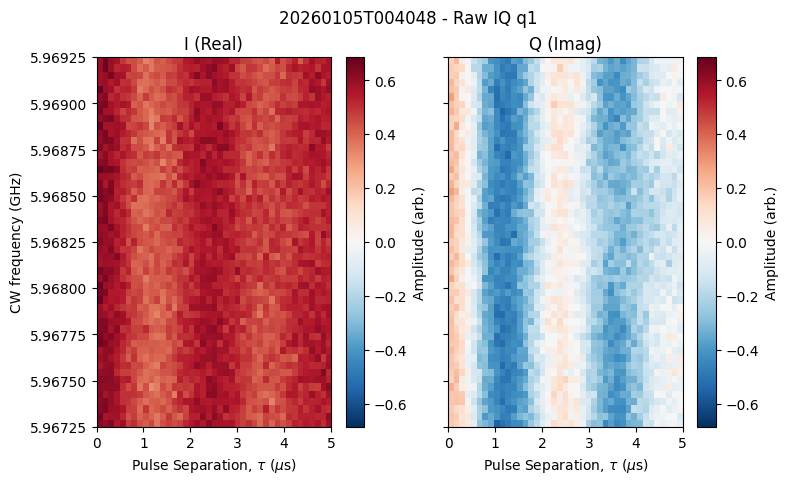

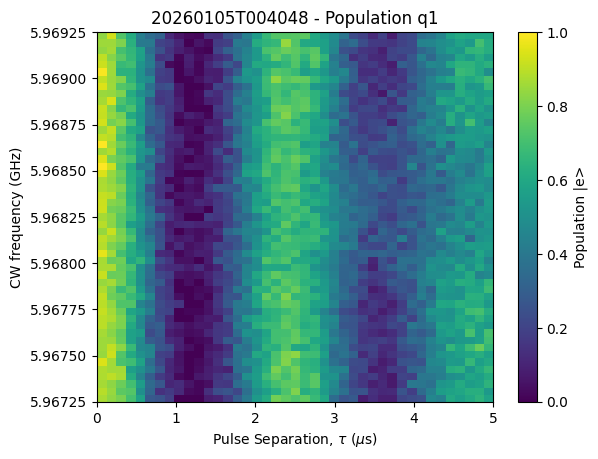

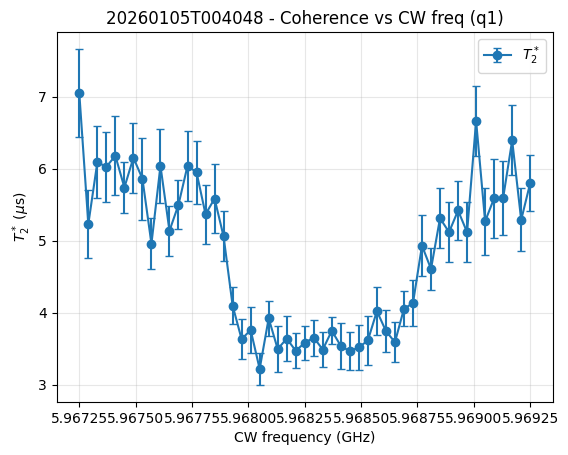

In [12]:
from experiments import coherence_spectroscopy


####################################################################################
q=qubits[1]
b=qubits[3]
temporary_parameters = {}
q_temp_pars =deepcopy(q.parameters)
q_temp_pars.readout_amplitude = 0.4
q_temp_pars.readout_integration_length =1.2e-6
b_temp_pars =deepcopy(b.parameters)
#b_temp_pars.readout_integration_length =1e-6
#b_temp_pars.spectroscopy_length = 10e-6
# b_temp_pars.drive_lo_frequency = 6.0e9
temporary_parameters[q.uid] = q_temp_pars
temporary_parameters[b.uid] = b_temp_pars

print(q.readout_parameters())

#####################################################################################
options = coherence_spectroscopy.experiment_workflow.options()
#workflow.show_fields(options)
options.count(256)
options.update(False)
options.do_analysis(True)
options.ring_up(1e-6)

######################################################################################
# Build and run resonator_spectroscopy_amplitude wormflow
co_spec = coherence_spectroscopy.experiment_workflow(
    session=session,
    qpu=qpu,
    qubit=q,
    bus= b,
    delays=np.linspace(0,5e-6,41), #delays=np.linspace(0,5e-6,21), 포인트 확보 중요
    CW_frequencies= b.parameters.resonance_frequency_ge+np.linspace(-1.0e6,1.0e6,51),
    #CW_frequencies= 5.5555e9 +np.linspace(-0.6e6,0.6e6,101),
    CW_amplitude=0.0018,
    CW_phase=0.0,
    detunings=0.4e6,
    temporary_parameters=temporary_parameters,
    options=options
)
co_spec_result = co_spec.run()
#co_spec_analysis_result = co_spec_result.tasks["analysis_workflow"]

In [ ]:
co_spec_result.tasks["analysis_workflow"].tasks

In [13]:
from laboneq.simple import show_pulse_sheet
from laboneq.contrib.example_helpers.plotting.plot_helpers import plot_simulation

show_pulse_sheet(compiled_experiment=co_spec_result.tasks["compile_experiment"].output,name='test', interactive=True)
#plot_simulation(compiled_experiment=co_spec_result.tasks["compile_experiment"].output)

[2026.01.05 12:24:53.614] INFO    Recompiling the experiment due to missing extra information in the compiled experiment. Compile with `OUTPUT_EXTRAS=True` and `MAX_EVENTS_TO_PUBLISH=1000` to bypass this step with a small impact on the compilation time.
[2026.01.05 12:24:53.616] INFO    Resolved modulation type of oscillator 'q1_readout_acquire_osc' on signal '/logical_signal_groups/q1/acquire' to SOFTWARE
[2026.01.05 12:24:53.616] INFO    Resolved modulation type of oscillator 'q1_drive_ge_osc' on signal '/logical_signal_groups/q1/drive' to HARDWARE
[2026.01.05 12:24:53.616] INFO    Resolved modulation type of oscillator 'q3_drive_ge_osc' on signal '/logical_signal_groups/q3/drive' to HARDWARE
[2026.01.05 12:24:53.616] INFO    Starting LabOne Q Compiler run...
[2026.01.05 12:24:54.946] INFO    Schedule completed. [1.329 s]
[2026.01.05 12:24:55.393] INFO    Code generation completed for all AWGs. [0.447 s]
[2026.01.05 12:24:55.394] INFO    Completed compilation step 1 of 1. [1.777 s]
[

In [ ]:
from experiments import amplitude_fine
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#temp_pars.ge_drive_amplitude_pi =0.64
#######################################################################
repetitions =np.arange(1,12) # Due to short T1, 20   
#######################################################################
options = amplitude_fine.experiment_workflow_x180.options()
options.update(False)
options.use_cal_traces(True)
#options.do_pca(False)

#print(workflow.show_fields(options))

###################################################################
error_amp = amplitude_fine.experiment_workflow_x180(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_result = error_amp.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_result.tasks['analysis_workflow'].output)

In [ ]:
from experiments import amplitude_fine
q = qubits[0]
temporary_parameters = {}
temp_pars =deepcopy(q.parameters)
temporary_parameters[q.uid] = temp_pars
#######################################################################
repetitions =np.arange(1,10)
#######################################################################
options = amplitude_fine.experiment_workflow_x90.options()
options.update(False)
options.use_cal_traces(True)
options.count(1024)

#print(workflow.show_fields(options))

###################################################################
error_amp_half = amplitude_fine.experiment_workflow_x90(
    session=session,
    qpu=qpu,
    qubits=q,
    repetitions=repetitions,
    temporary_parameters=temporary_parameters,
    options=options
)

error_amp_half_result = error_amp_half.run()
#qubit_spec_compiled = session.compile(amplitude_rabi.create_experiment(qpu=qpu,qubit=q,amplitudes=amplitudes, options=options))
print(error_amp_half_result.tasks['analysis_workflow'].output)

In [ ]:
from helper import load_qubit_parameters, save_qubit_parameters
save_qubit_parameters(qubits={ qubit.uid : qubit for qubit in qubits}, save_folder="./qubit_parameters/", filename="COSPEC2")